# R estimation from Denmark, Ontario, Britain, and Switzerland

## Methodology

Each dataset contains the following:
* Omicron variant case for a region, from testing
* Non-omicron variant case for a region, from testing
* Total cases for a region

We assume that the portion of Omicron variant in the tested sample is the same as the Omicron variant in the region.

With that assumption, the number of Omicron cases in a region is imputed.

The generation time of the Omicron variant is assumed to be the same as other variants. We use the value from [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7201952/), which gives a generation time of 5.2 days.

The last ten days of imputed number of Omicron cases in a region is used to fit an exponential function of the form $y = ae^{bx}$

$ R_t $ is calcuated as $ R_t = e^{5.2b} $

$ R_0 $ calculations are also provided. The only difference from $ R_t $ is that those use the values from the _first_ ten days with data.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib.offsetbox import AnchoredText
import numpy as np

In [2]:
GEN_TIME = 5.2
MIN_DATAPOINTS = 5

In [3]:
owid = pd.read_csv('./data/owid_global/owid-covid-data.csv')
owid['date'] = pd.to_datetime(owid['date'])

In [4]:
# Fit the function y = A * exp(B * x) to the data
# returns (A, B)
# From: https://mathworld.wolfram.com/LeastSquaresFittingExponential.html
def fit_exp(xs, ys):
    S_x2_y = 0.0
    S_y_lny = 0.0
    S_x_y = 0.0
    S_x_y_lny = 0.0
    S_y = 0.0
    for (x,y) in zip(xs, ys):
        S_x2_y += x * x * y
        S_y_lny += y * np.log(y)
        S_x_y += x * y
        S_x_y_lny += x * y * np.log(y)
        S_y += y
    #end
    a = (S_x2_y * S_y_lny - S_x_y * S_x_y_lny) / (S_y * S_x2_y - S_x_y * S_x_y)
    b = (S_y * S_x_y_lny - S_x_y * S_y_lny) / (S_y * S_x2_y - S_x_y * S_x_y)
    return (np.exp(a), b)

In [5]:
def exp_func(x, a, b):
    return a*np.exp(b*x)

In [6]:
def get_r_from_fit(a,b):
    t0 = exp_func(0, a, b)
    t1 = exp_func(GEN_TIME, a, b)
    return t1/t0

In [7]:
def impute_and_fit(df):
    imputed = df['new_cases'] * (df['sgtf_count']/(df['non_sgtf_count'] + df['sgtf_count']))
    fit_df = df.copy()
    fit_df['imputed_omicron'] = imputed
    fit_df.sort_values('date')
    fit_df = fit_df[fit_df['imputed_omicron'] > 0]

    first_date = fit_df['date'].min()
        
    days = (df['date'] - first_date).dt.days
    
    rt_mask = df['date'] >= first_date
    
    fit_df['days'] = (fit_df['date'] - first_date).dt.days
    
    at, bt = fit_exp(fit_df.loc[rt_mask, 'days'], fit_df.loc[rt_mask, 'imputed_omicron'])

    fitted_t = exp_func(days, at, bt)
    
    implied_rt = get_r_from_fit(at, bt)
    
    joins = pd.DataFrame({
        'imputed_omicron': imputed,
        'days': days,
        'fitted_t': fitted_t,
        'date': df['date'],
        'rt_mask': rt_mask,
    })
    return joins, implied_rt
    

In [8]:
def show_omicron(df, implied_rt, region_name, figsize=(20,10), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_yscale('log')
    ax.scatter(df['date'], df['new_cases'], label="Daily New Cases")
    ax.scatter(df['date'], df['imputed_omicron'], label="Imputed Omicron Cases")
    ax.plot(df[df['rt_mask']]['date'], df[df['rt_mask']]['fitted_t'], label="Fitted Omicron Cases", color="#F39C12")
    anchored_text = AnchoredText("Implied R {:.2f}".format(implied_rt), loc=3, prop=dict(size=15))
    ax.legend(loc=2)
    ax.add_artist(anchored_text)
    ax.set_title("{} Omicron Progression".format(region_name))
    return None, ax

In [9]:
denmark_owid = owid[owid['iso_code'] == 'DNK']

In [10]:
rt_dict = {}

## Denmark

Let's look at Denmark first, with data retreived from the [Statens Serum Institut](https://covid19.ssi.dk/virusvarianter/delta-pcr)



In [11]:
denmark_csv = pd.read_csv('./data/denmark/denmark_numbers.csv', delimiter=" ", decimal=",")

In [12]:
denmark_csv['date'] = pd.to_datetime(denmark_csv['date'])

denmark_df = pd.merge(denmark_owid[['date', 'new_cases']], denmark_csv, how="inner")
denmark_df['sgtf_count'] = denmark_df['omicron_pcr']
denmark_df['non_sgtf_count'] = denmark_df['positive_pcr'] - denmark_df['omicron_pcr']

In [13]:
joins, implied_rt= impute_and_fit(denmark_df)
denmark_df = denmark_df.merge(joins)
rt_dict["Denmark"] = {'r': implied_rt, 'n': (denmark_df['sgtf_count']>0).sum(), 'sequenced': denmark_df['sgtf_count'].max()}

[]

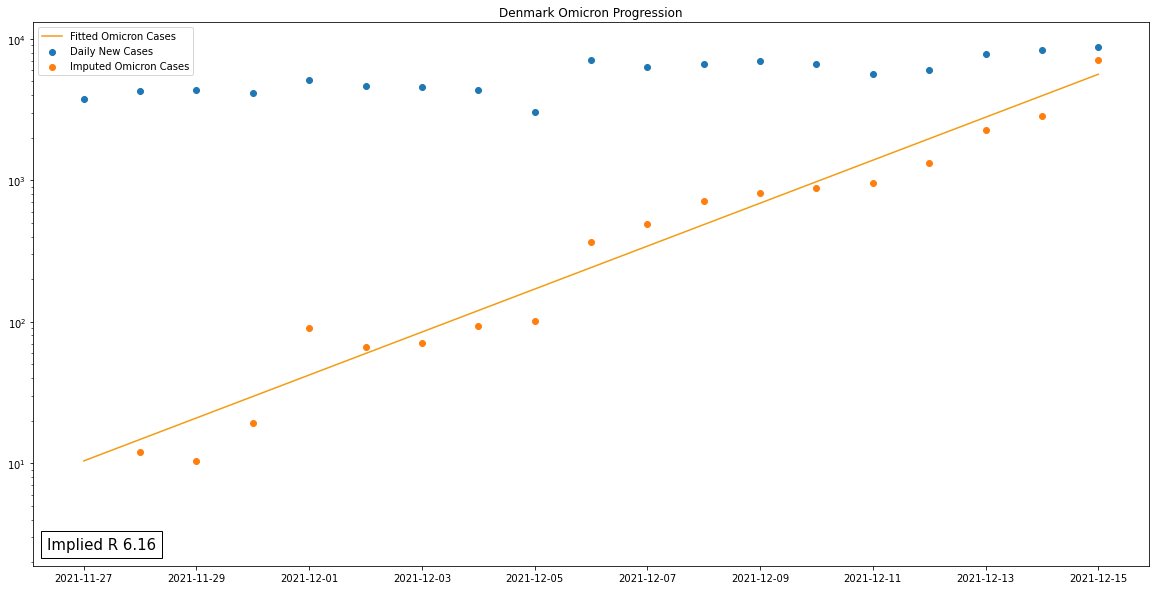

In [14]:
fig, axes = show_omicron(denmark_df, implied_rt, "Denmark")
axes.plot()

## Ontario

[Public Health Ontario's Report](https://www.publichealthontario.ca/-/media/documents/ncov/epi/covid-19-early-dynamics-omicron-ontario-epi-summary.pdf?sc_lang=en) does not provide direct numbers but does provide a chart from which data can be extracted with [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) 

S Gene Targeting Failure is used as a proxy for Omicron variant testing, since Delta, the other prevelant variant of concern, has its S gene targeted successfully.

In [15]:
ontario_sgtf_csv = pd.read_csv('./data/ontario/sgtf_ontario.csv', header=None).rename(mapper={0: 'date', 1: 'sgtf_count'}, axis=1)
ontario_non_sgtf_csv = pd.read_csv('./data/ontario/non-SGTF_ontario.csv', header=None).rename(mapper={0: 'date', 1: 'non_sgtf_count'}, axis=1)

In [16]:
ontario_csv = pd.merge(ontario_sgtf_csv, ontario_non_sgtf_csv, how="outer", on=None)
ontario_csv['date'] = pd.to_datetime(ontario_csv['date'])

In [17]:
ontario_base = pd.read_csv('./data/ontario/covidtesting.csv')
ontario_base['date'] = pd.to_datetime(ontario_base['Reported Date'])
ontario_base['new_cases'] = ontario_base['Confirmed Positive']

In [18]:
ontario_df = pd.merge(ontario_csv, ontario_base[['date', 'new_cases']], how='inner')
ontario_df.sort_values('date', inplace=True)

# hard remove one data point from 2021-11-08

ontario_df.loc[ontario_df['date'] == pd.to_datetime('2021-11-08'),'sgtf_count'] = 0

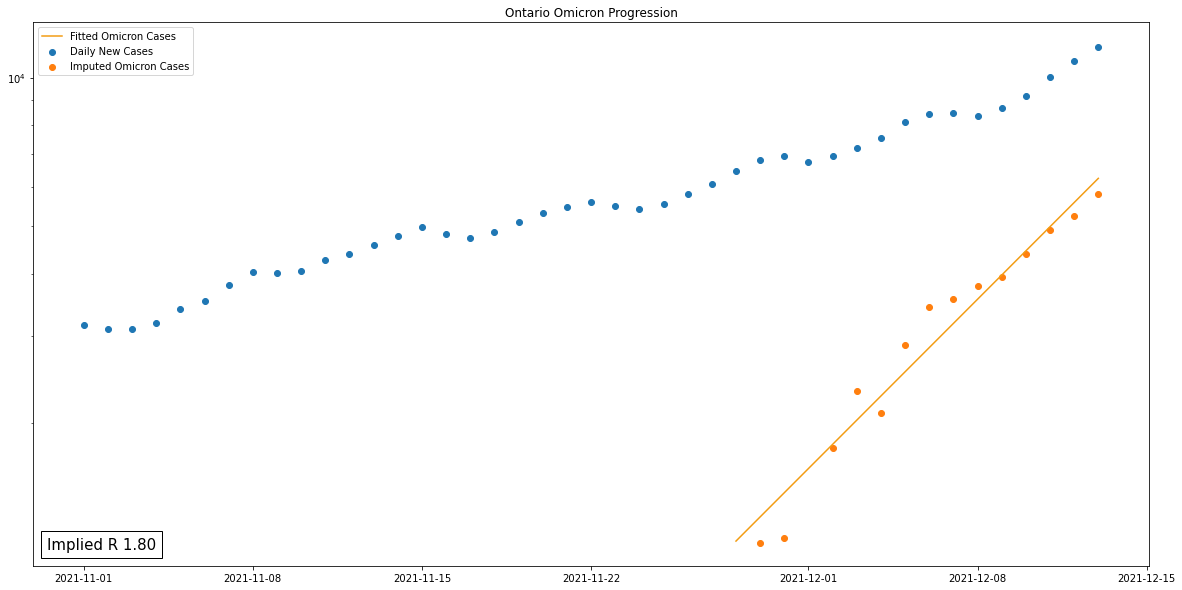

In [19]:
joins, implied_rt = impute_and_fit(ontario_df)
ontario_df = ontario_df.merge(joins)
rt_dict["Ontario"] = {'r': implied_rt, 'n': (ontario_df['sgtf_count']>0).sum(), 'sequenced': ontario_df['sgtf_count'].max()}
fig, axes = show_omicron(ontario_df, implied_rt, "Ontario")

## Britain

Britain has suffered heavily from Omicron as well. Data sourced from [Theo Anderson's Github](https://gist.github.com/theosanderson/1a37c2bb7ecc541ec93501556a0bc545), and can be downloaded from [UK Coronavirus Dashboard](https://coronavirus.data.gov.uk/details/download)


In [20]:
britain_base = pd.read_csv('./data/britain/region_2021-12-17.csv')
britain_strain = pd.read_csv('./data/britain/sgtf_regionepicurve_2021-12-16-2.csv')

In [21]:
britain_strain['sgtf_count'] = britain_strain.apply(lambda x: 0 if x['sgtf'] != 'Cases with confirmed SGTF' else x['n'], axis=1)
britain_strain['non_sgtf_count'] = britain_strain.apply(lambda x: 0 if x['sgtf'] == 'Cases with confirmed SGTF' else x['n'], axis=1)

In [22]:
britain_base['date'] = pd.to_datetime(britain_base['date'])
britain_base['new_cases'] = britain_base['newCasesBySpecimenDate']

britain_strain['date'] = pd.to_datetime(britain_strain['specimen_date'])
britain_strain['areaName'] = britain_strain['PHEC_name']

britain_base_agg = britain_base.groupby(['date', 'areaName']).aggregate({'new_cases': 'sum'}).reset_index()

britain_strain_agg = britain_strain.groupby(['date', 'areaName']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum'}).reset_index()

britain_df = britain_base_agg.merge(britain_strain_agg)

britain_agg_df = britain_df.groupby(['date']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum', 'new_cases': 'sum'}).reset_index()

[]

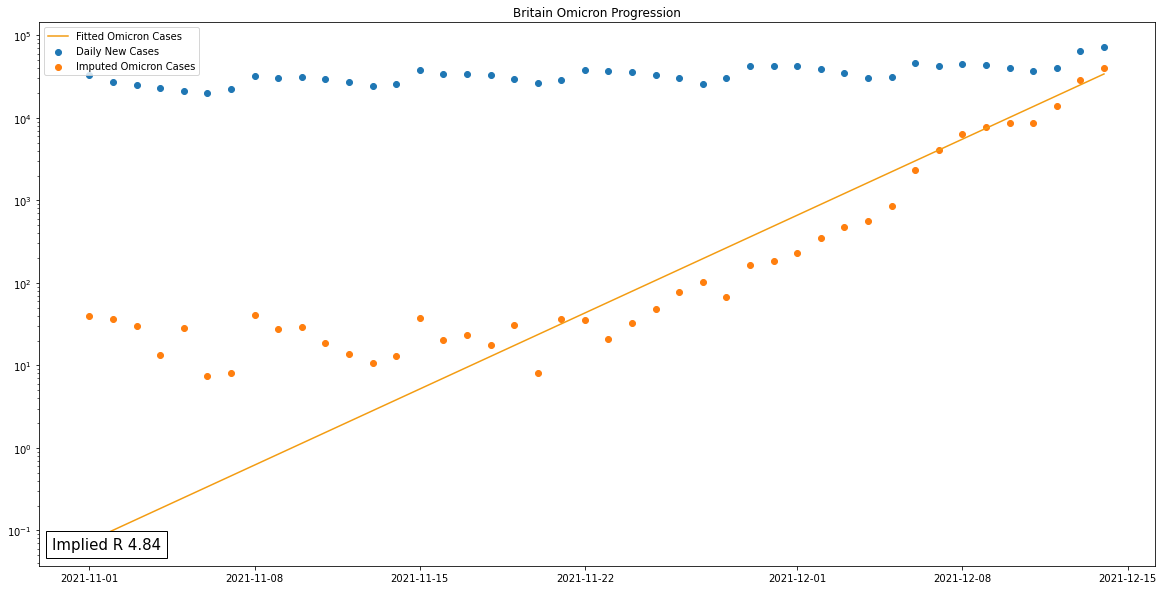

In [23]:
joins, implied_rt = impute_and_fit(britain_agg_df)
britain_agg_df = britain_agg_df.merge(joins)
fig, axes = show_omicron(britain_agg_df, implied_rt, "Britain")
axes.plot()

## Switzerland

Switzerland's [Federal Office of Public Health](https://www.covid19.admin.ch/en/epidemiologic/virus-variants) has a full set of data available.

The case data (in blue) looks like distinct "belts" of points, due to intraweek variation in data collection


The Omicron strain is labelled B.1.1.529

In [24]:
swiss_base = pd.read_csv('./data/switzerland/data/COVID19Cases_geoRegion.csv')
swiss_strain = pd.read_csv('./data/switzerland/data/COVID19Variants_wgs.csv')

In [25]:
swiss_strain['sgtf_count'] = swiss_strain.apply(lambda x: x['entries'] if x['variant_type'] == 'B.1.1.529' else 0, axis=1)
swiss_strain['non_sgtf_count'] = swiss_strain.apply(lambda x: 0 if x['variant_type'] == 'B.1.1.529' else x['entries'], axis=1)
swiss_strain['date'] = pd.to_datetime(swiss_strain['date'])
swiss_strain_agg = swiss_strain.groupby(['date', 'geoRegion']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum'}).reset_index()

In [26]:
swiss_base['date'] = pd.to_datetime(swiss_base['datum'])
swiss_base['new_cases'] = swiss_base['entries']

swiss_base_agg = swiss_base.groupby(['date', 'geoRegion']).aggregate({'new_cases': 'sum'}).reset_index()

swiss_df = pd.merge(swiss_base_agg, swiss_strain_agg, how='inner')

swiss_agg_df = swiss_df.groupby(['date']).aggregate({'sgtf_count': 'sum', 'non_sgtf_count': 'sum', 'new_cases': 'sum'}).reset_index()

(None, <AxesSubplot:title={'center':'Switzerland Omicron Progression'}>)

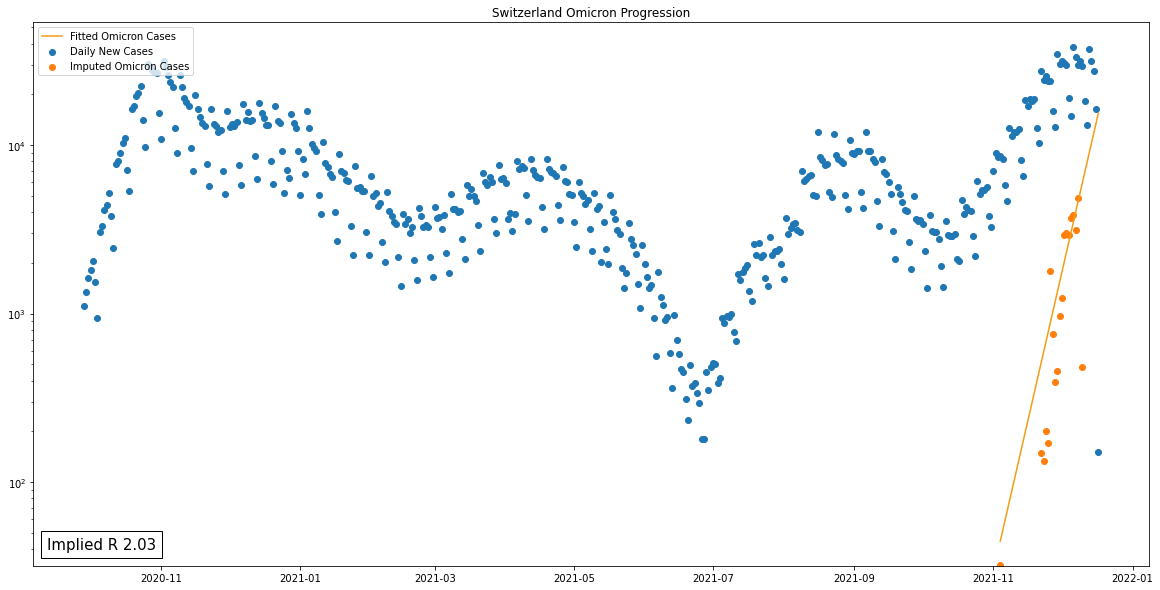

In [27]:
joins, implied_rt = impute_and_fit(swiss_agg_df)
swiss_agg_df = swiss_agg_df.merge(joins)
show_omicron(swiss_agg_df, implied_rt, "Switzerland")

In [28]:
def show_aggregate_omicron(df, areaKey, grid, outerName, figsize=(50,50), labelsize=16, xtickSkip=None):
    fig, axes = plt.subplots(grid[0], grid[1], figsize=figsize)
    areaNames = df[areaKey].unique()

    i = 0
    for areaName in areaNames:
        ax = axes[i//grid[1], i%grid[1]]
        sub_df = df[df[areaKey] == areaName]
        sub_df = sub_df[sub_df['sgtf_count'] > 0]
        if len(sub_df.index) < MIN_DATAPOINTS:
            continue
        try:
            joins, implied_rt = impute_and_fit(sub_df)
            fullName = "{}: {}".format(outerName, areaName)
            rt_dict[fullName] = {'r': implied_rt, 'n': (sub_df['sgtf_count']>0).sum(), 'sequenced': sub_df['sgtf_count'].max()}
            sub_df = sub_df.merge(joins)
            sub_df = sub_df[sub_df['imputed_omicron'] > 0]
            show_omicron(sub_df, implied_rt, fullName, ax=ax)
            ax.xaxis.set_tick_params(labelsize=labelsize)
            ax.yaxis.set_tick_params(labelsize=labelsize)
            if xtickSkip is not None:
                ax.set_xticks(ax.get_xticks()[::xtickSkip])
            i += 1
        except Exception as exception:
            print(len(sub_df.index), areaName)
            print("Exception: {}".format(type(exception).__name__))
            print("Exception message: {}".format(exception))
    return fig, axes

## Disaggregation

### Britain by Area

Britain's data has regional data.

Be careful in interpreting the below data. Omicron became known to the world in the middle of November, but Britain's data has cases since November 1st.

[Global patient zero](https://news.sky.com/story/covid-19-how-the-spread-of-omicron-went-from-patient-zero-to-all-around-the-globe-12482183) was detected on November 11th, and therefore, SGTF data before that will not be used.

In [29]:
cutoff = pd.to_datetime('2021-11-11')
britain_cutoff_df = britain_df[britain_df['date'] >= cutoff]

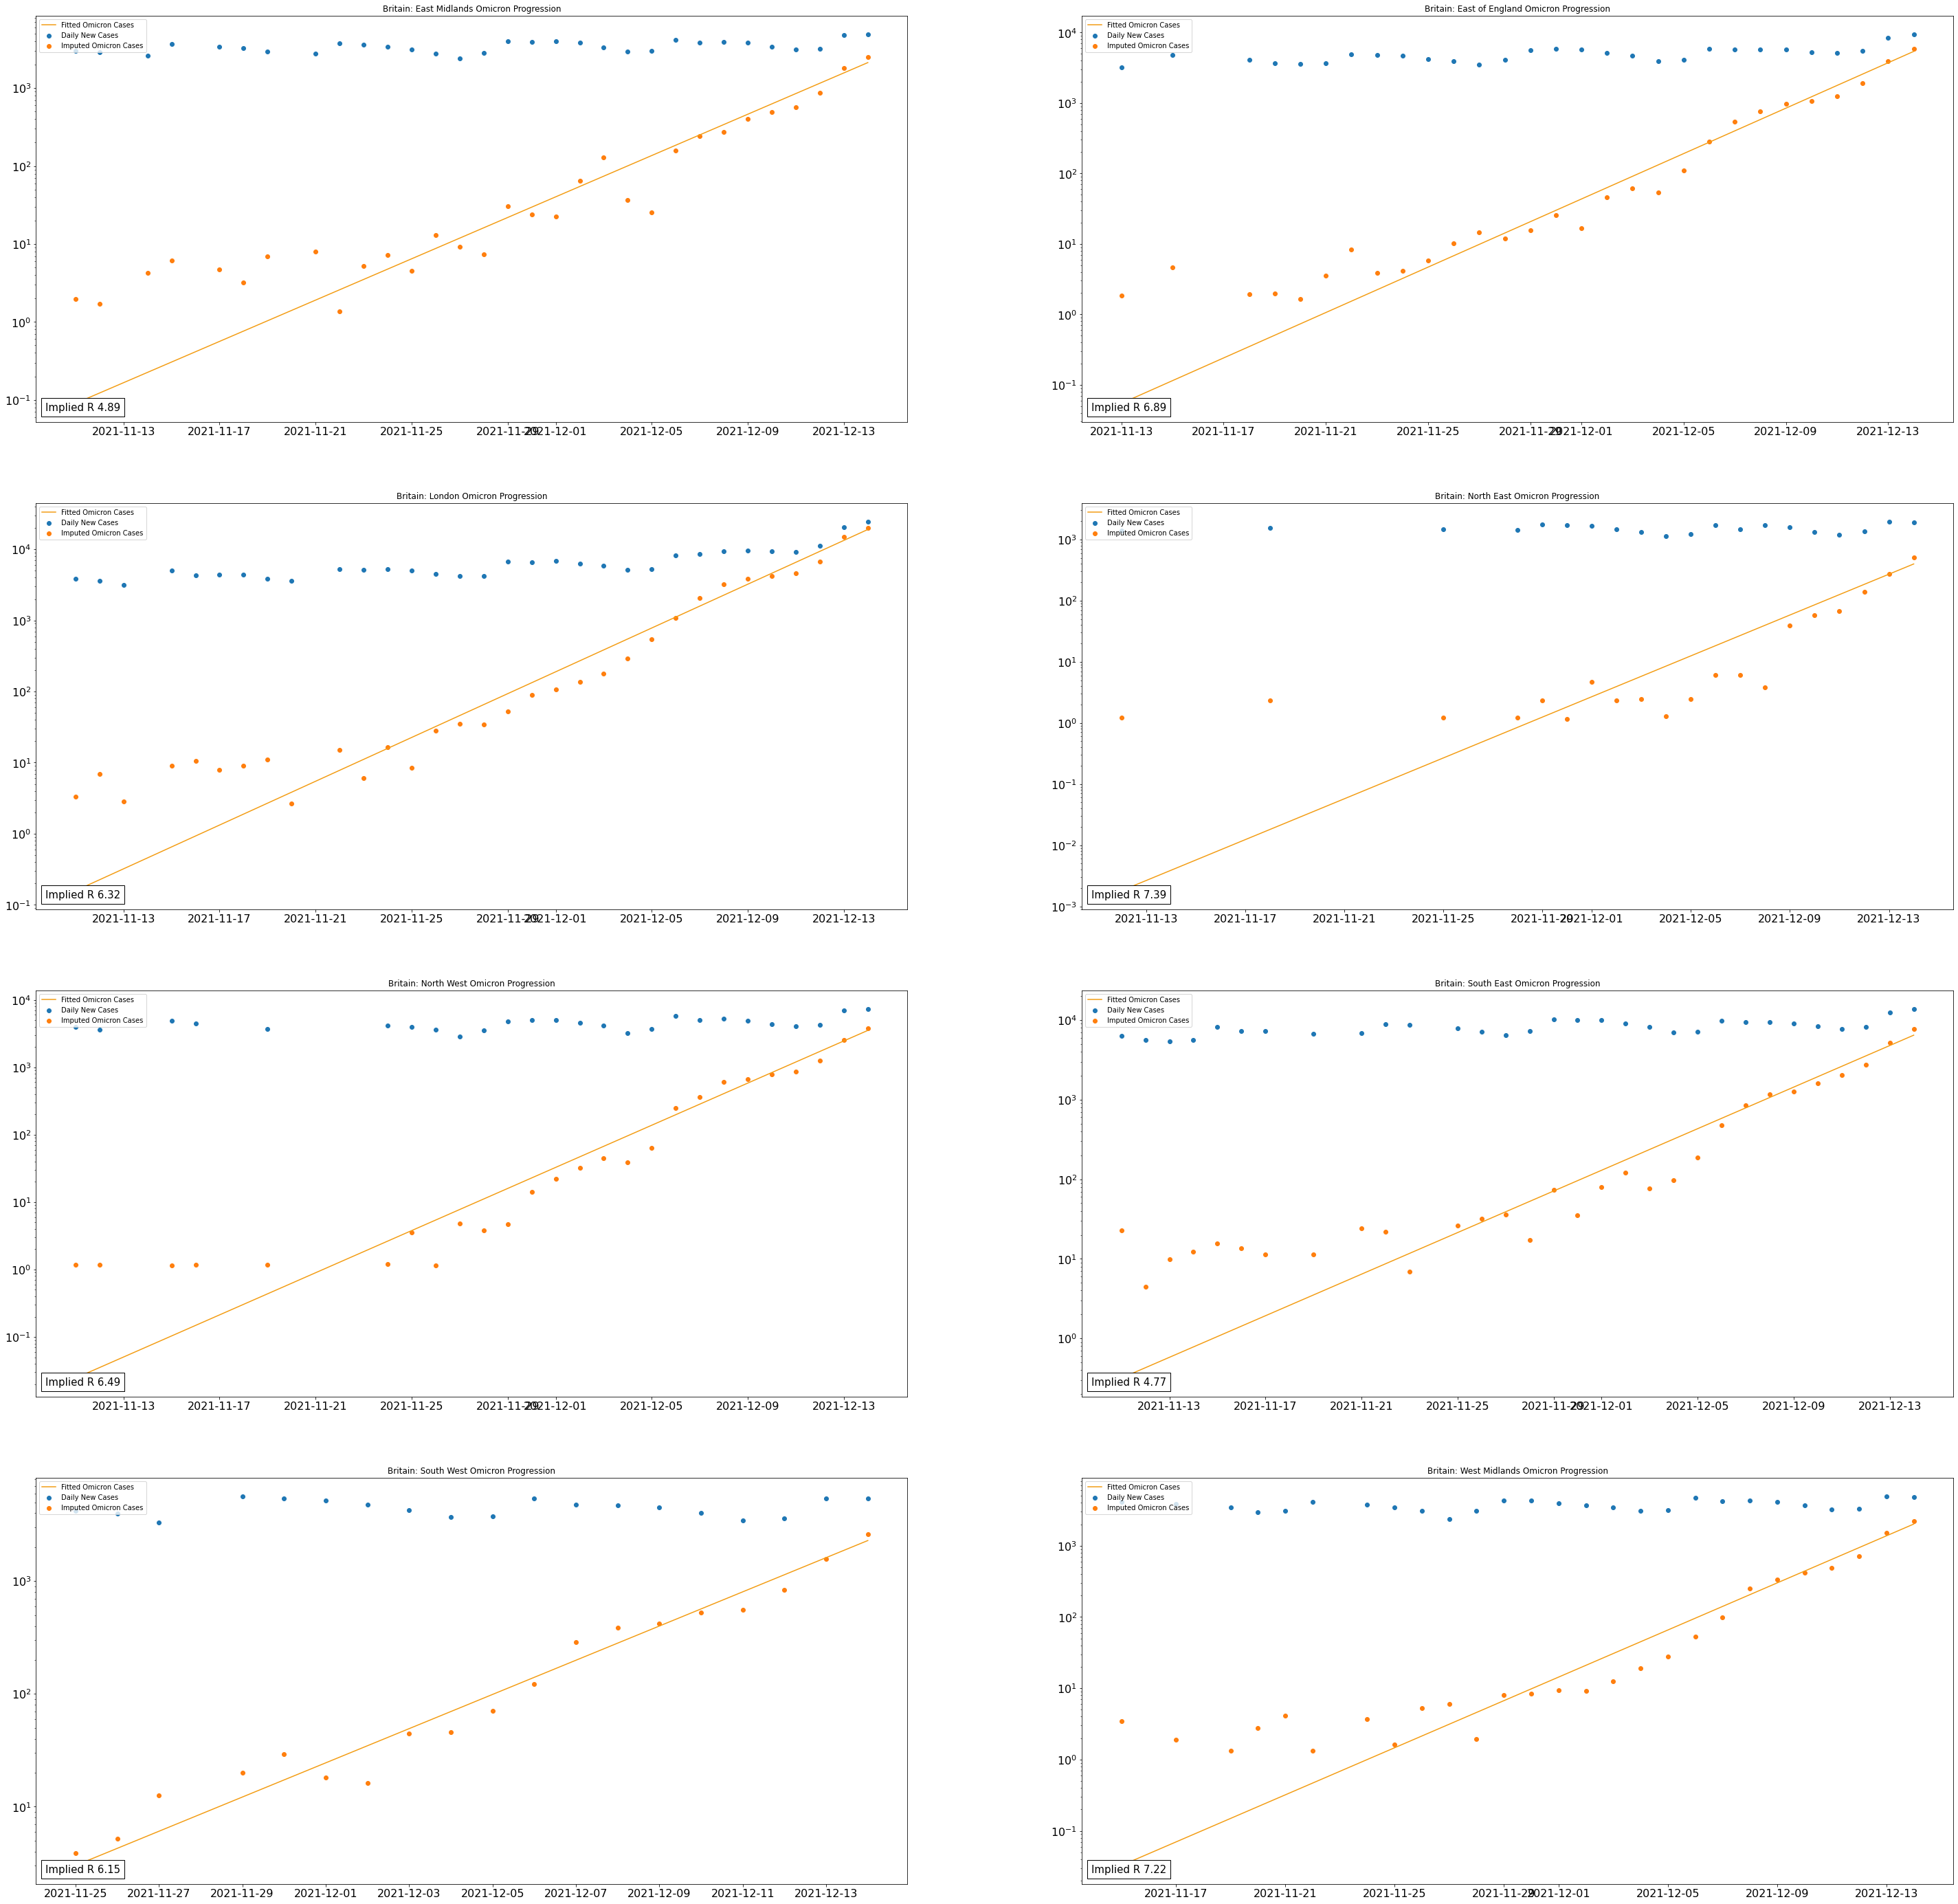

In [30]:
fig, axes = show_aggregate_omicron(britain_cutoff_df, 'areaName', (4,2), 'Britain')
plt.show()

### Switzerland by Georegion

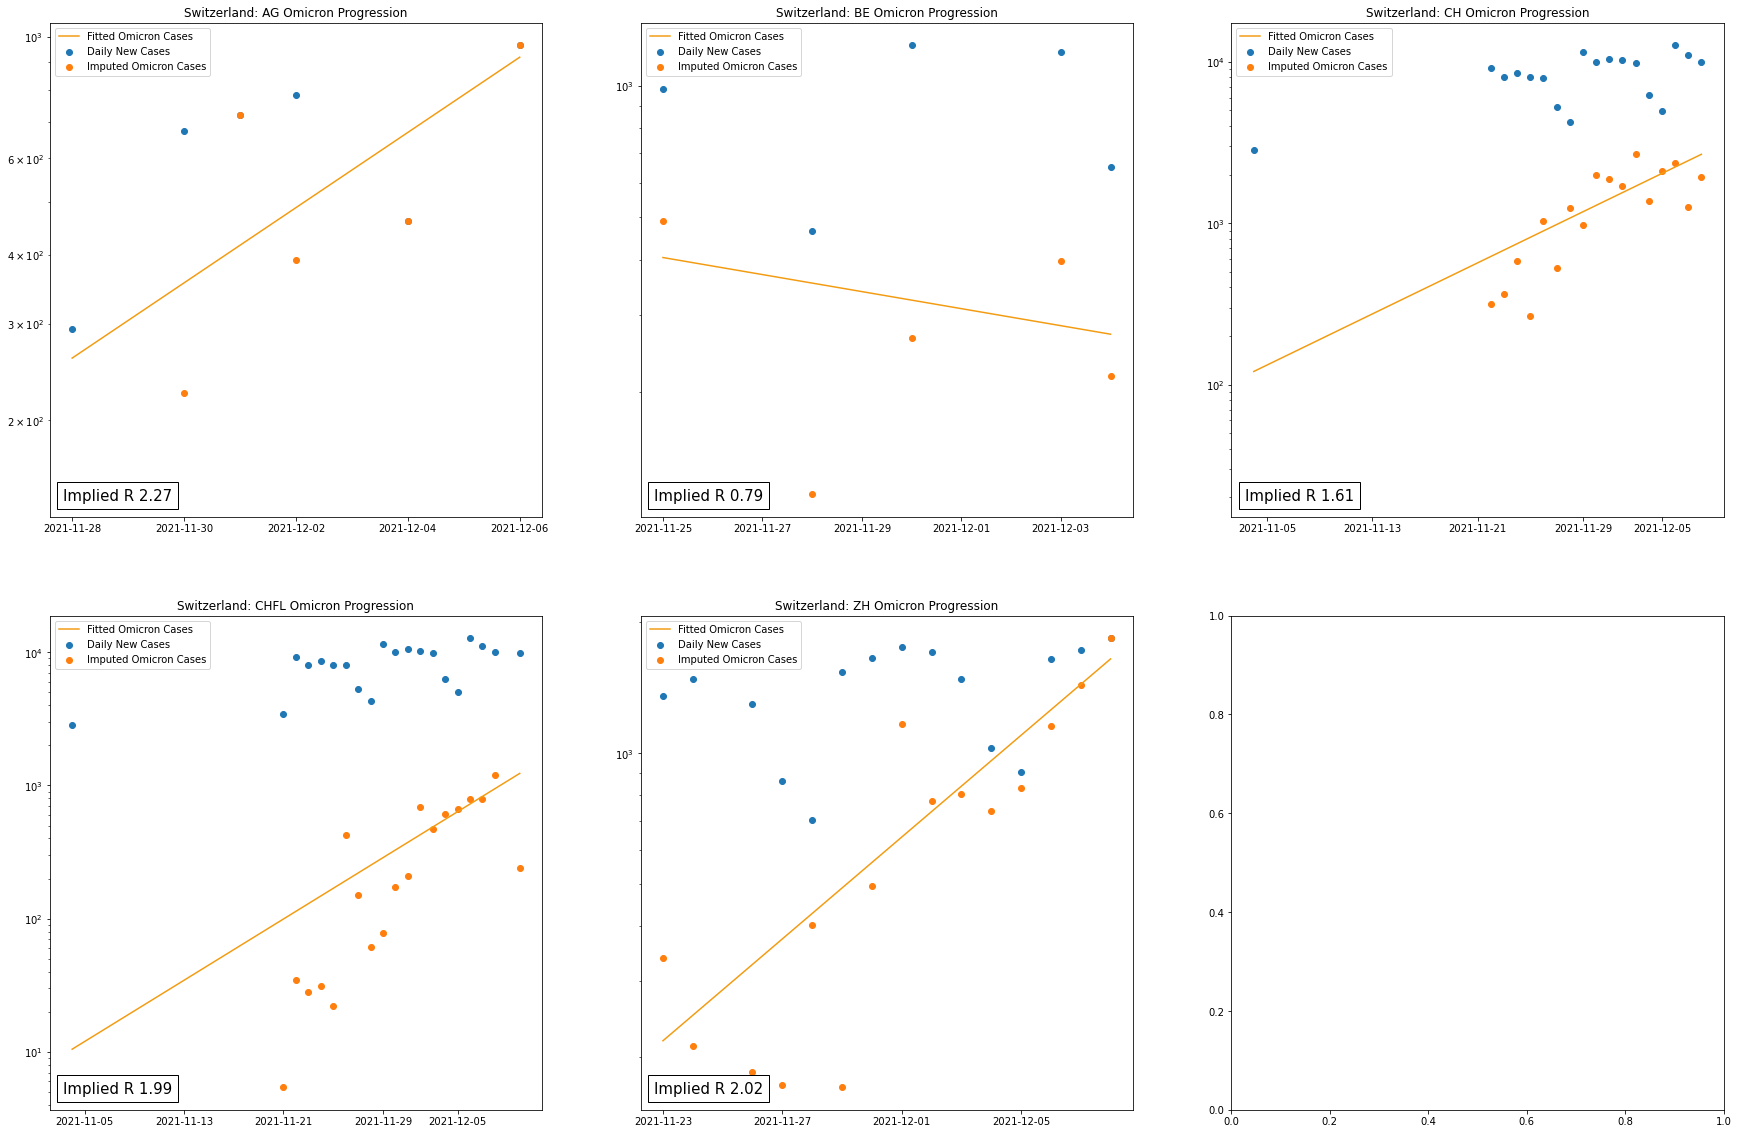

In [31]:
fig, axes = show_aggregate_omicron(swiss_df, 'geoRegion', (2,3), 'Switzerland', figsize=(30,20), labelsize=10, xtickSkip=2)
plt.show()

## ECDC

The below data is extracted from the [ECDC Newsroom](https://www.ecdc.europa.eu/en/news-events), from Newsletters of the format: `Epidemiological update: Omicron variant of concern (VOC) – data as of 14 December 2021 (12:00)`

In [32]:
ecdc_folder = './data/eu/ecdc'
import os

ecdc_arr = []
for file in os.listdir(ecdc_folder):
    filepath = "{}/{}".format(ecdc_folder, file)
    with open(filepath, 'r') as f:
        countries_dict = {}
        content = f.read()
        if '\n' not in content:
            snippets = content.split('),')
            for snippet in snippets:
                country, num = snippet.split('(')
                country = country.replace('the ', '').strip()
                num = ''.join([k for k in num if k.isdigit()])
                countries_dict[country] = int(num)
                ecdc_arr.append([file, country, int(num)])
        else:
            prev = None
            for line in content.split('\n'):
                line = line.strip()
                if len(line) == 0:
                    continue
                if line.isnumeric():
                    countries_dict[prev] = line
                    ecdc_arr.append([file, prev, int(line)])
                    prev = None
                else:
                    prev = line
ecdc_df = pd.DataFrame(ecdc_arr, columns=['date', 'country', 'count'])
ecdc_df['date'] = pd.to_datetime(ecdc_df['date'])
            

ecdc_df = ecdc_df.groupby(['country', 'count']).aggregate({'date': 'min'}).reset_index()

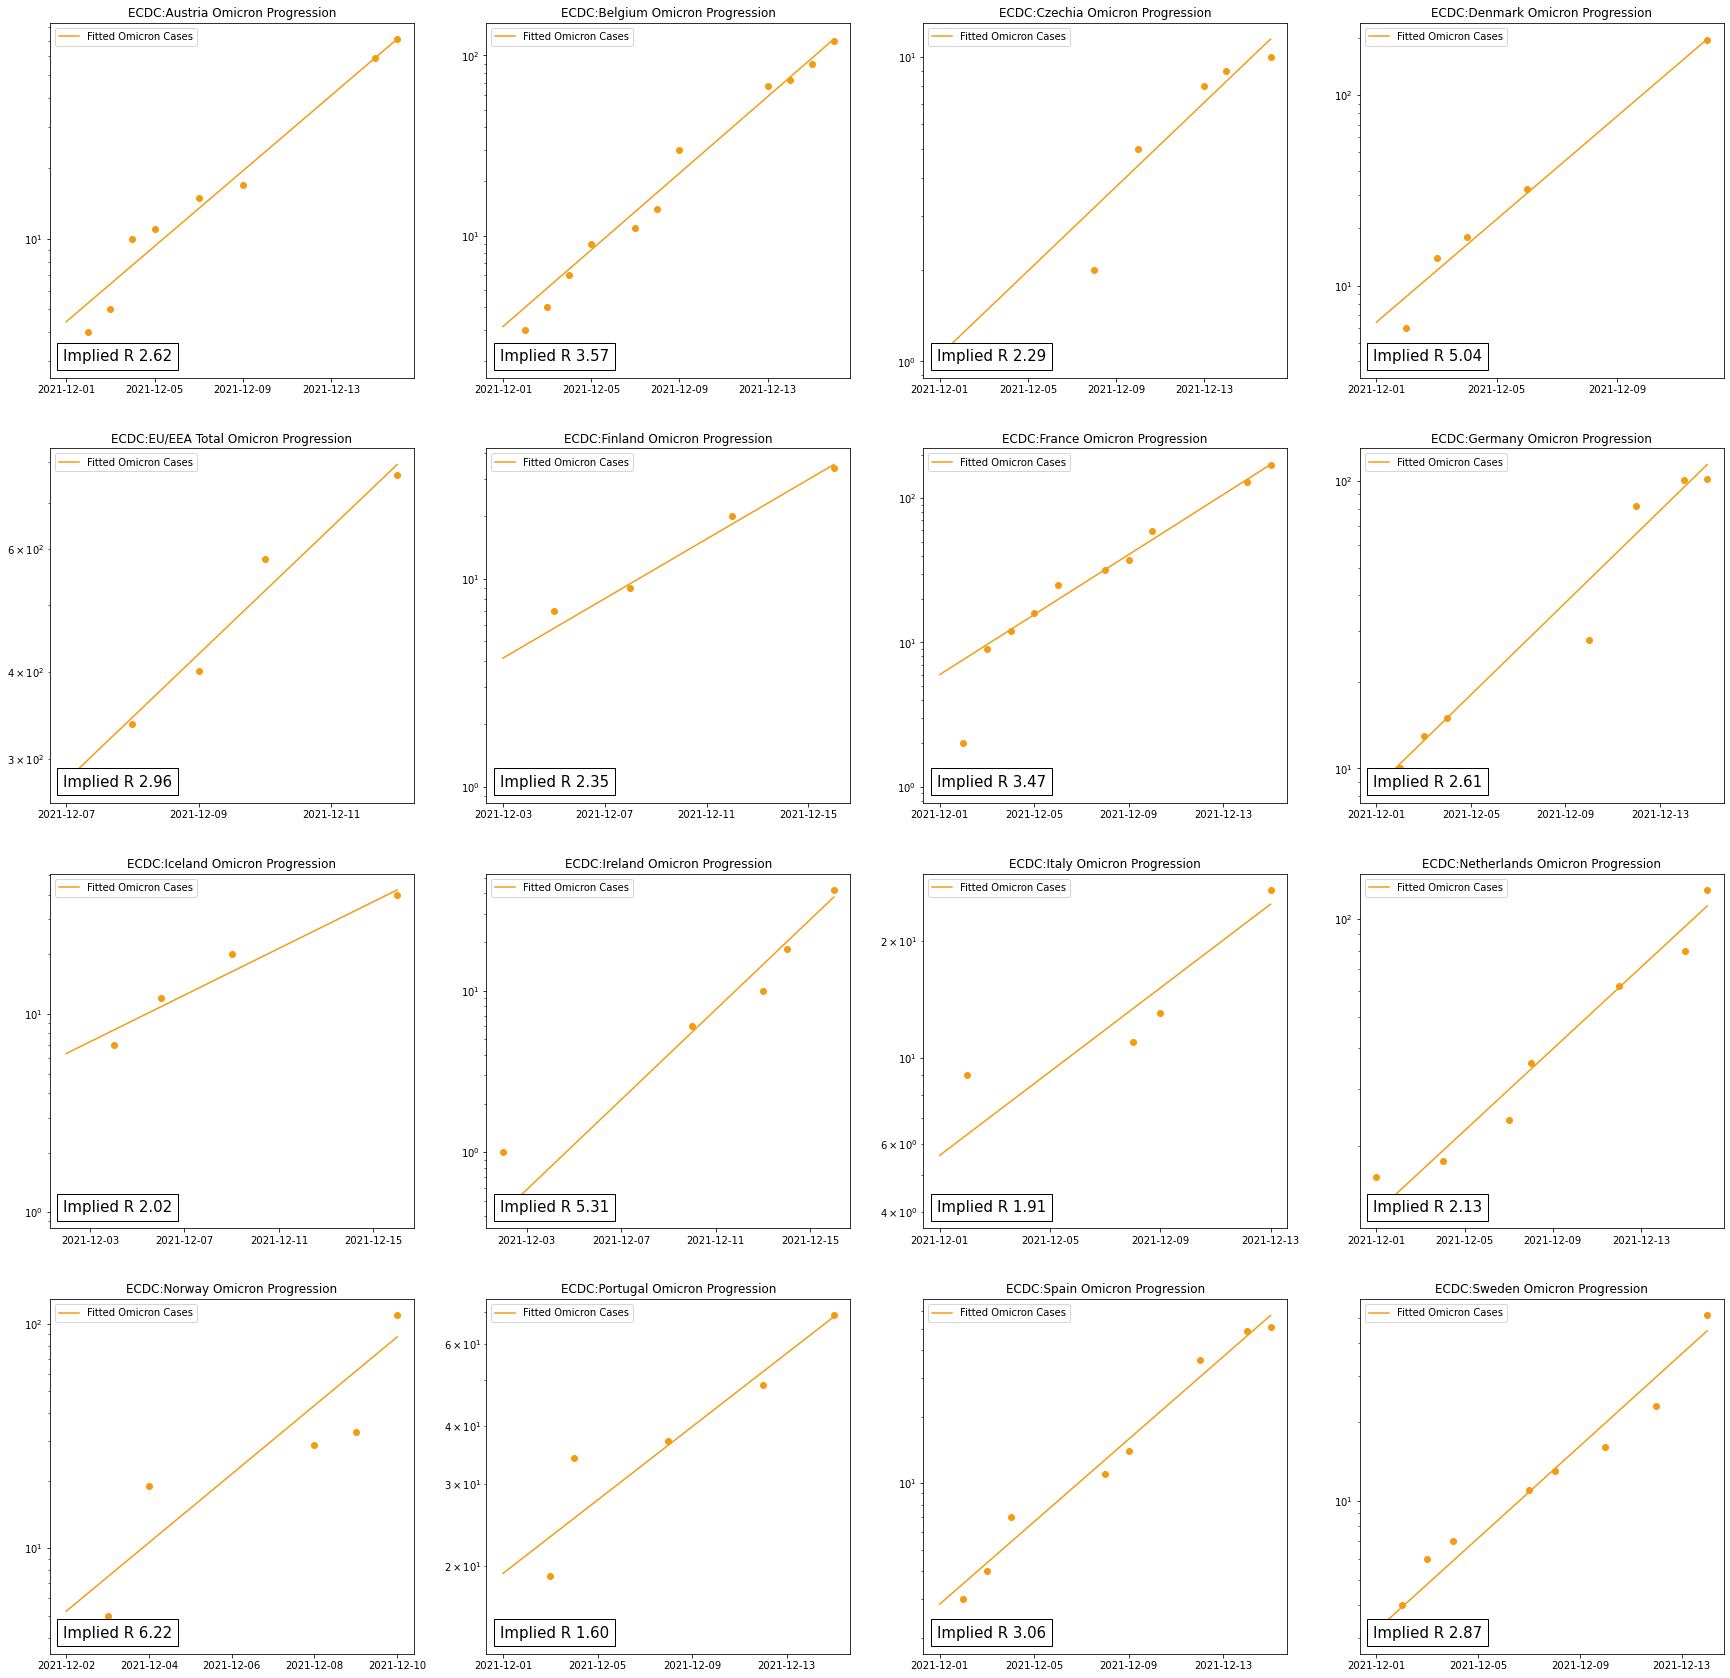

In [33]:
grid = (4,4)
figsize = (30, 30)
fig, axes = plt.subplots(grid[0], grid[1], figsize=figsize)
i = 0
for country in ecdc_df['country'].unique():
    sub_df = ecdc_df[ecdc_df['country'] == country]
    sub_df = sub_df[sub_df['count'] > 0]
    if len(sub_df.index) < MIN_DATAPOINTS:
        continue
    sub_df.sort_values('date').reset_index()
    first_date = sub_df['date'].min()
    days = np.array((sub_df['date'] - first_date).dt.days)
    at, bt = fit_exp(days, sub_df['count'])

    fitted_t = exp_func(days, at, bt)
    implied_rt = get_r_from_fit(at, bt)
    
    ax = axes[i//grid[1], i%grid[1]]
    ax.set_yscale('log')
    ax.scatter(sub_df['date'], sub_df['count'], color="#F39C12")
    ax.plot(sub_df['date'], fitted_t, label="Fitted Omicron Cases", color="#F39C12")
    anchored_text = AnchoredText("Implied R {:.2f}".format(implied_rt), loc=3, prop=dict(size=15))
    ax.legend(loc=2)
    ax.add_artist(anchored_text)
    ax.set_title("ECDC:{} Omicron Progression".format(country))
    ax.set_xticks(ax.get_xticks()[::2])
    rt_dict["ECDC: {}".format(country)] = {'r': implied_rt, 'n': len(sub_df.index), 'sequenced': sub_df['count'].max()}
    i += 1
    

In [34]:
rt_dict_items = list(rt_dict.items())
rs = [v['r'] for k,v in rt_dict_items]
ns = [v['n'] for k,v in rt_dict_items]
maxs = [v['sequenced'] for k,v in rt_dict_items]
names = [k for k,v in rt_dict_items]
weighted_r = np.average(rs, weights=ns)

In [35]:
print(weighted_r)

4.561481812200438


## Finding R

The determined R value is 4.56, given a generation time of 5.2.

This is derived by taking the weighted average of the calculated R values from all the aforementioned data. The weight is the number of days of data that is provided for that region.


## Heterogeneity

It appears that the ECDC data show low sequenced/SGTF numbers, has a low number of datapoints, and low calculated R value.

The British numbers show high sequenced/SGTF numbers, has a high number of datapoints, and a high calculated R value.

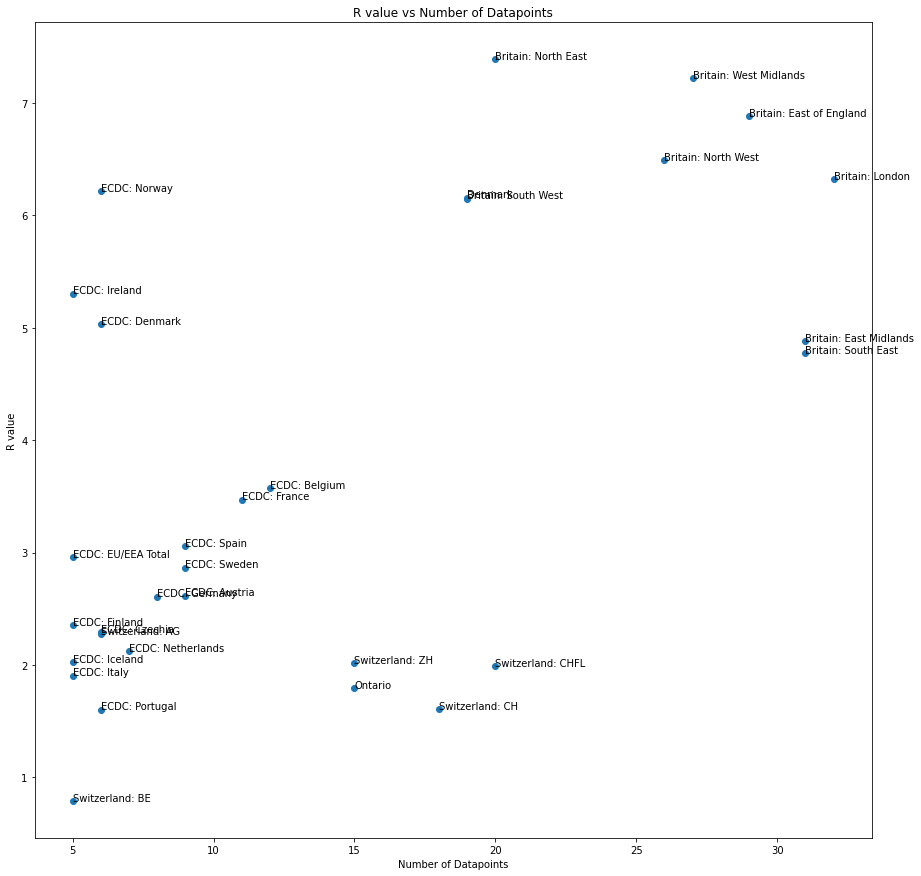

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(ns, rs)
for i, label in enumerate(names):
    ax.annotate(label, (ns[i], rs[i]))
ax.set_ylabel("R value")
ax.set_xlabel("Number of Datapoints")
rn = linregress(ns,rs)
ax.set_title("R value vs Number of Datapoints")
plt.show()


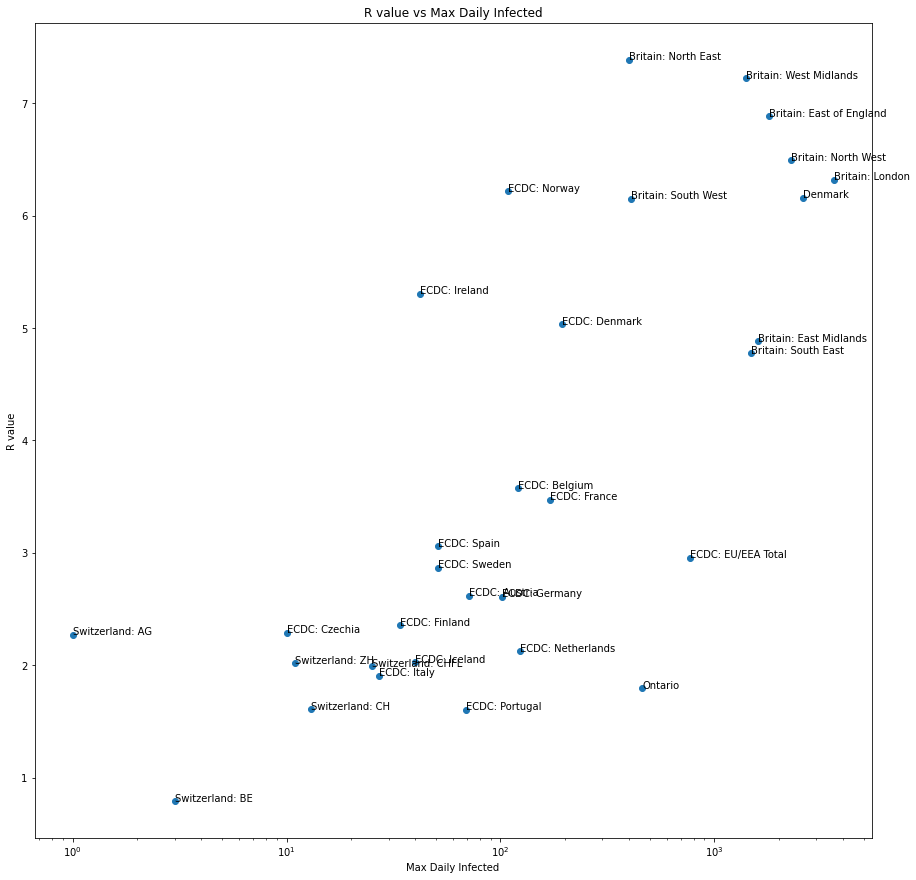

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(maxs, rs)
for i, label in enumerate(names):
    ax.annotate(label, (maxs[i], rs[i]))
ax.set_ylabel("R value")
ax.set_xlabel("Max Daily Infected")
rn = linregress(maxs,rs)
ax.set_xscale('log')
ax.set_title("R value vs Max Daily Infected")
plt.show()
